In [ ]:
!pip install xarray
!pip install rasterio
!pip install geopandas
!pip install boto3 s3fs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━

In [ ]:
!pip install rioxarray
!pip install cartopy
#!pip install netCDF4 h5netcdf zarr
#!pip install fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.9 MB/s eta 0:00:00


In [ ]:
import boto3
import requests
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd


################### INPUTS #####################

year = 2030
var1 = 'RUNOFF'
var2 = 'BASEFLOW'

base_url = "https://wrf-cmip6-noversioning.s3.amazonaws.com/lusu/CEC/VIC_SIMULATIONS/GCMs/LOCA2/ACCESS-CM2/r1i1p1f1_ssp370"

runoff_file = os.path.join(base_url,var1, f"{year}.nc")
baseflow_file = os.path.join(base_url,var2, f"{year}.nc")

runoff_ds = xr.open_dataset(runoff_file)
baseflow_ds = xr.open_dataset(baseflow_file)


#### READ SHAPE FILE
shapefile_path = r'/content/drive/MyDrive/Colab_Notebooks/PostDoc_Project1_Pywr/CLIMATE_JOHN/data_shapefiles/Tuo.shp'
gdf = gpd.read_file(shapefile_path)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Text(0.5, 1.0, 'Total Runoff')

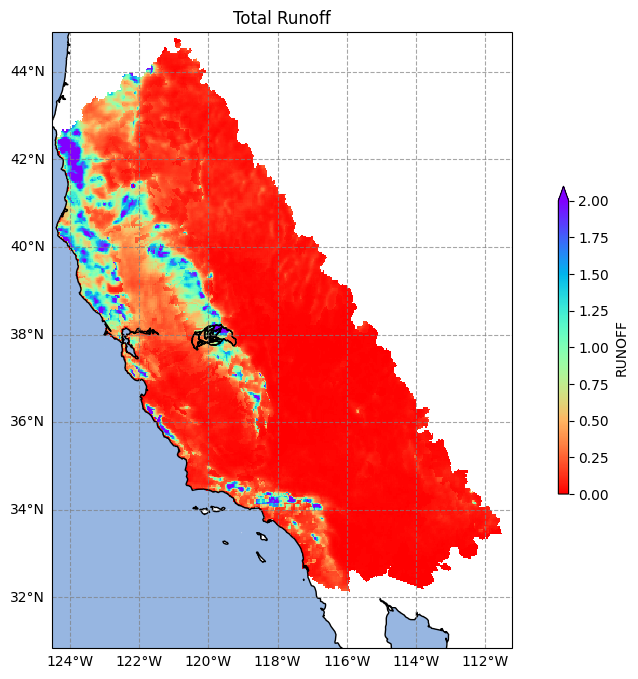

In [ ]:
######################################## PLOT RUNOFF OF ALL CALIFORNIA ###########################################

yearly_mean = runoff_ds.RUNOFF.mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.OCEAN)

gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# Plot the yearly mean runoff
pc = yearly_mean.plot.pcolormesh(ax=ax, cmap='rainbow_r', vmin=0, vmax=2,
                                cbar_kwargs={'orientation': 'vertical', 'pad': 0.06, 'shrink': 0.5, 'aspect': 30})

gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1)
ax.set_title('Total Runoff')


Text(0.5, 1.0, 'Total Baseflow')

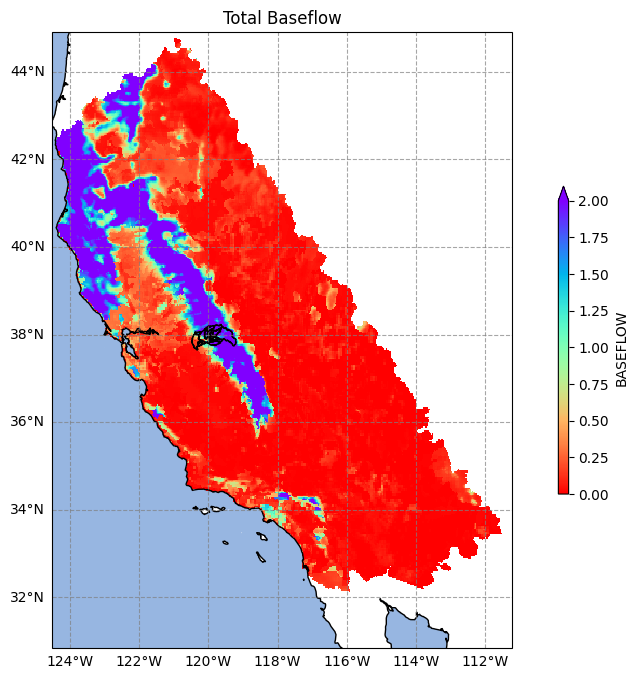

In [ ]:
################################# PLOT BASEFLOW OF ALL CALIFORNIA ######################################

yearly_mean = baseflow_ds.BASEFLOW.mean(dim='time')

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.OCEAN)

gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# Plot the yearly mean runoff
pc = yearly_mean.plot.pcolormesh(ax=ax, cmap='rainbow_r', vmin=0, vmax=2,
                                cbar_kwargs={'orientation': 'vertical', 'pad': 0.06, 'shrink': 0.5, 'aspect': 30})

gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1)
ax.set_title('Total Baseflow')



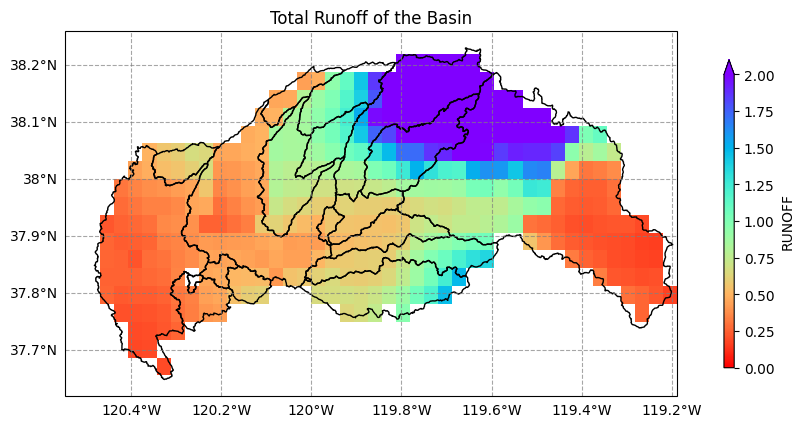

In [ ]:
#data = xr.open_dataset('/content/drive/MyDrive/Colab_Notebooks/PostDoc_Project1_Pywr/CLIMATE_JOHN/2015.nc')

data = runoff_ds            # Baseflow_ds

# Set spatial dimensions and CRS
data = data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gdf.to_crs(data.rio.crs)
geometries = gdf.geometry
clipped_data = data.rio.clip(geometries.geometry[0:18], gdf.crs)                  ## 19 subbasins
ds_clipped = clipped_data

yearly_mean_clipped = ds_clipped.RUNOFF.mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.OCEAN)

gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

pc = yearly_mean_clipped.plot.pcolormesh(ax=ax, cmap='rainbow_r', vmin=0, vmax=2,
                                         cbar_kwargs={'orientation': 'vertical', 'pad': 0.06, 'shrink': 0.5, 'aspect': 30})

gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1)
ax.set_title('Total Runoff of the Basin')

plt.show()


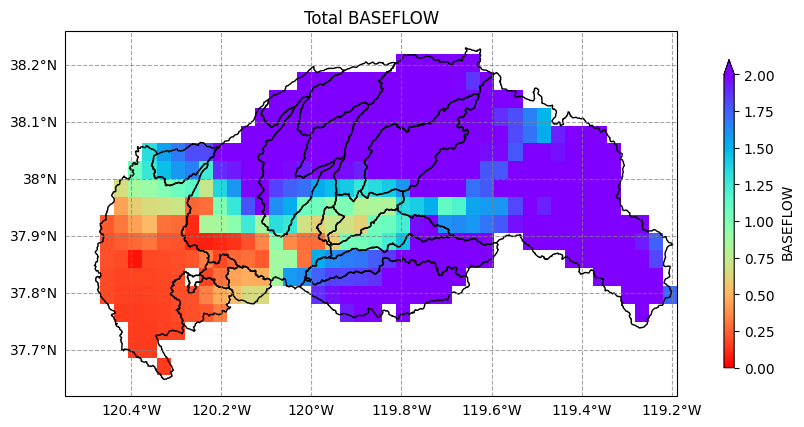

In [ ]:

data = baseflow_ds
data = data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

gdf = gdf.to_crs(data.rio.crs)

geometries = gdf.geometry


clipped_data = data.rio.clip(geometries.geometry[0:18], gdf.crs)

ds_clipped = clipped_data
yearly_mean_clipped = ds_clipped.BASEFLOW.mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.OCEAN)

gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}
pc = yearly_mean_clipped.plot.pcolormesh(ax=ax, cmap='rainbow_r', vmin=0, vmax=2,
                                         cbar_kwargs={'orientation': 'vertical', 'pad': 0.06, 'shrink': 0.5, 'aspect': 30})

gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1)

ax.set_title('Total BASEFLOW')

plt.show()

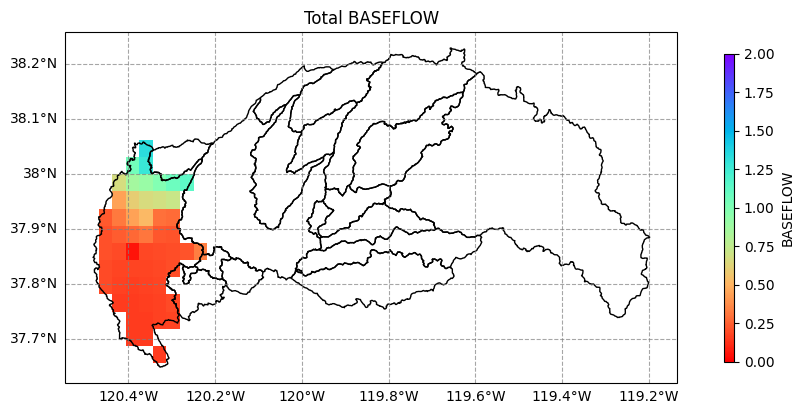

In [ ]:

data = baseflow_ds
data = data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

gdf = gdf.to_crs(data.rio.crs)

geometries = gdf.geometry


ds_clipped = data.rio.clip(geometries.geometry[0:1], gdf.crs)

yearly_mean_clipped = ds_clipped.BASEFLOW.mean(dim='time')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.OCEAN)

gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}
pc = yearly_mean_clipped.plot.pcolormesh(ax=ax, cmap='rainbow_r', vmin=0, vmax=2,
                                         cbar_kwargs={'orientation': 'vertical', 'pad': 0.06, 'shrink': 0.5, 'aspect': 30})

gdf.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1)
ax.set_title('Total BASEFLOW')

plt.show()


In [ ]:
import numpy as np
import boto3
import requests
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import logging

np.set_printoptions(precision=14)
pd.set_option('display.float_format', '{:.14f}'.format)


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()



start_year = 2030        #2025-2050, 2050-2075, 2075-2100
end_year = 2051
GCM = "ACCESS-CM2"
var1 = 'RUNOFF'
var2 = 'BASEFLOW'
Basin = "Tuolumne"       # Merced, San Joaquin, Stainslus

base_url = "https://wrf-cmip6-noversioning.s3.amazonaws.com/lusu/CEC/VIC_SIMULATIONS/GCMs/LOCA2/" + GCM + "/r1i1p1f1_ssp370"

#### READ SHAPE FILE
shapefile_path = r'/content/drive/MyDrive/Colab_Notebooks/PostDoc_Project1_Pywr/CLIMATE_JOHN/data_shapefiles/Tuo.shp'
gdf = gpd.read_file(shapefile_path)


for i in range(end_year - start_year):

    start_time = time.time()
    syear = start_year + i

    print(f"Starting extracting for year {syear}")

    runoff_file = os.path.join(base_url,var1, f"{syear}.nc")
    baseflow_file = os.path.join(base_url,var2, f"{syear}.nc")

    runoff_ds = xr.open_dataset(runoff_file)
    baseflow_ds = xr.open_dataset(baseflow_file)

    #### Extract the Runoff of each sub basin
    data1 = runoff_ds
    data1 = data1.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data1 = data1.rio.write_crs("epsg:4326", inplace=True)
    gdf1 = gdf.to_crs(data1.rio.crs)
    geometries1 = gdf1.geometry

    #### Extract the Basflow of each sub basin
    data2 = baseflow_ds
    data2 = data2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data2 = data2.rio.write_crs("epsg:4326", inplace=True)
    gdf2 = gdf.to_crs(data2.rio.crs)
    geometries2 = gdf2.geometry

    ############# Clip and Aggrgate
    #sub_basins = {}

    start_date = f"{syear}-01-01"
    end_date = f"{syear}-12-31"
    date_range = pd.date_range(start=start_date, end=end_date)



    for j in range(len(gdf)):

        key = gdf.SUBWAT[j]       # sub basin name

        clipped_runoff = data1.rio.clip(geometries1.geometry[j:j+1], gdf1.crs)
        clipped_baseflow = data2.rio.clip(geometries2.geometry[j:j+1], gdf2.crs)

        areas = (111/32)**2 * np.cos(np.radians(clipped_runoff.lat.values))* 1_000_000
        areas = xr.DataArray(areas, coords={"lat": clipped_runoff["lat"]}, dims=["lat"]).broadcast_like(clipped_runoff["RUNOFF"])

        runoff_mcm = (clipped_runoff["RUNOFF"] * areas)/1_000_000  # Convert mm/day to MCM/day
        clipped_runoff["RUNOFF"] = runoff_mcm
        baseflow_mcm = (clipped_baseflow["BASEFLOW"] * areas)/1_000_000  # Convert mm/day to MCM/day
        clipped_baseflow["BASEFLOW"] = baseflow_mcm

        agg_runoff = np.sum(clipped_runoff.RUNOFF, axis=(0, 1))
        agg_baseflow = np.sum(clipped_baseflow.BASEFLOW, axis=(0, 1))

        sum = agg_runoff + agg_baseflow

        #if key not in sub_basins:
        #    sub_basins[key] = sum

        csv_file = "/content/drive/MyDrive/Colab_Notebooks/PostDoc_Project1_Pywr/CLIMATE_JOHN/results_ACCESS-CM2_Tuolumne/LOCA2_" + GCM + "_runoff_baseflow_" + Basin + "_" + key + "_mcm.csv"
        if os.path.exists(csv_file):
            df_existing = pd.read_csv(csv_file)
        else:
            df_existing = pd.DataFrame(columns=["date", "flw"])

        df_new = pd.DataFrame({"date": date_range,"flw": sum})

        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')

        #df_combined['date'] = df_combined['date'].dt.date

        df_combined.to_csv(csv_file, index=False)

        print(f"Sub basin: {key} of year: {syear} is complete!")

    end_time = time.time()
    print(f"Year {syear} is accomplished in time: {(end_time - start_time)/60} mins")




Starting extracting for year 2025
Sub basin: TUO_01 of year: 2025 is complete!
Sub basin: TUO_02 of year: 2025 is complete!
Sub basin: TUO_03 of year: 2025 is complete!
Sub basin: TUO_04 of year: 2025 is complete!
Sub basin: TUO_05 of year: 2025 is complete!
Sub basin: TUO_06 of year: 2025 is complete!
Sub basin: TUO_07 of year: 2025 is complete!
Sub basin: TUO_08 of year: 2025 is complete!
Sub basin: TUO_09 of year: 2025 is complete!
Sub basin: TUO_10 of year: 2025 is complete!
Sub basin: TUO_11 of year: 2025 is complete!
Sub basin: TUO_12 of year: 2025 is complete!
Sub basin: TUO_13 of year: 2025 is complete!
Sub basin: TUO_14 of year: 2025 is complete!
Sub basin: TUO_15 of year: 2025 is complete!
Sub basin: TUO_16 of year: 2025 is complete!
Sub basin: TUO_17 of year: 2025 is complete!
Sub basin: TUO_18 of year: 2025 is complete!
Sub basin: TUO_19 of year: 2025 is complete!
Year 2025 is accomplished in time: 10.230651978651682 mins
Starting extracting for year 2026
Sub basin: TUO_01 